# Описание задачи
## В задачи пректа входит:
- Обработка предоставленных данных: нахождение и заполнение пропусков, кодировка, нормализация признаков;
- Создание новых признаков с использованием предоставленных данных;
- Отбор признаков;
- Обучение и тестирование модели на полученных признаках;
- Оптимизация размера набора данных и подбор макропараметров модели на оптимизированном наборе;
- Получение предсказанных моделью значений, подготовка и отправка submission

## Описание датасета
Первоначальная версия датасета состоит из 14-ти столбцов, содержащих следующую информацию:

- **client_id** - идентификатор клиента
- **education** - уровень образования
- **sex** - пол заёмщика
- **age** - возраст заёмщика
- **car** - флаг наличия автомобиля
- **car_type**	- флаг автомобиля-иномарки
- **decline_app_cnt** - количество отказанных прошлых заявок
- **good_work** - флаг наличия «хорошей» работы
- **bki_request_cnt** - количество запросов в БКИ
- **home_address** - категоризатор домашнего адреса
- **work_address** - категоризатор рабочего адреса
- **income** - доход заёмщика
- **foreign_passport** - наличие загранпаспорта
- **sna** - связь заемщика с клиентами банка
- **first_time** - давность наличия информации о заемщике
- **score_bki** - скоринговый балл по данным из БКИ
- **region_rating** - рейтинг региона
- **app_date** - дата подачи заявки
- **default** - наличие дефолта (целевая переменная)

# Импорт библиотек, установка параметров, определение функций

In [72]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, learning_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

import os

In [179]:
# функции используемые в ноутбуке
def df_describe(df):
    desc = df.describe(include='all',percentiles=[0.5]).T
    desc['type'] = [type(x) for x in df.iloc[0]]
    desc['NaN'] = df.isna().sum()
    desc.unique = df.nunique()
    desc.top = df.mode(axis=0).iloc[0]
    desc.freq = [df[col].value_counts().iloc[0] for col in  df.columns]
    return desc

def nums_visualisation(df,annotation=False):
    columns = df.columns
    cols_num = df.shape[1]
    
    fstr = '\033[1m{}\033[0m, '* (len(columns)-1) + '\033[1m{}\033[0m'
    if annotation: print(('Всего признаков этого типа {}. К ним относятся: ' + fstr).format(len(columns),*columns))

    indent = 0.05
    fig = plt.figure(figsize=(15,3))
    for i,col in enumerate(columns):
        row = df[col]
        min_diff = pd.Series(row.unique()).sort_values().diff().min()
        bins = min(int((row.max()-row.min()) /min_diff + 1),100)
        
        fig.add_axes([1/cols_num*i, 0.35, 1/cols_num-indent, 1])
        plt.title(col)
        row.plot.hist(bins=bins,density=True)
    
        fig.add_axes([1/cols_num*i, 0, 1/cols_num-indent, 0.2])
        sns.boxplot(x=row)

    plt.tight_layout()

def num_visualisation(row,hue): 
    row1 = row[hue==0]
    row2 = row[hue==1]
    
    min_diff = pd.Series(row.unique()).sort_values().diff().min()
    bins = min(int((row.max()-row.min()) /min_diff + 1),100)
    bins_range = row.min()-min_diff/2 ,row.max()+min_diff/2 

    fig = plt.figure(figsize=(15,5))
    
    ax1 = fig.add_axes([0, 0.4, 1, 1])
    row1.plot.hist(bins=bins,density=True,alpha = 0.65)
    row2.plot.hist(bins=bins,density=True,alpha = 0.65)
    plt.legend(['negative','positive'])
    
    ax2 = fig.add_axes([0, 0, 1, 0.30]) 
    ax1.get_shared_x_axes().join(ax1, ax2)
    sns.boxplot(data = [row1,row2],orient='h',saturation = 0.5)

    
def cats_visualisation(df):
    columns = df.columns
    cols_num = df.shape[1]
    
    fstr = '\033[1m{}\033[0m, '* (len(columns)-1) + '\033[1m{}\033[0m'
    print(('Всего признаков этого типа {}. К ним относятся: ' + fstr).format(len(columns),*columns))
    
    indent = 0.05
    fig = plt.figure(figsize=(14,3))
    for i,col in enumerate(columns):
        row = df[col]
        bins = df.shape[1]
        
        fig.add_axes([1/cols_num*i, 0, 1/cols_num-indent, 1])
        plt.title(col)
        sns.countplot(data[col])
    
def cat_visualisation(row):
    feat_name = row.name
    fig, axes = plt.subplots(1,2,figsize = (14,5))
    
    hue = data.default
    
    dist_1 = pd.DataFrame({'neg':row[hue==0].value_counts(normalize=True),
                           'pos':row[hue==1].value_counts(normalize=True)})
    ind = dist_1.index
    dist_2 = pd.DataFrame({'neg':data.groupby(feat_name).default.value_counts(normalize=True)[:,0],
                           'pos':data.groupby(feat_name).default.value_counts(normalize=True)[:,1]}).loc[ind]
    
    display(dist_2.T)
    dist_1.plot.bar(title = 'Распределение категорий '+ feat_name + '\n при разных значениях default',ax = axes[0])
    dist_2.plot.bar(title = 'Распределение default в каждой категории '+ feat_name,ax = axes[1],stacked=True)
    plt.legend(loc = 4)
    
def pre_process(data):
    df = copy(data)
    label_encoder = LabelEncoder()
#     scaler = MinMaxScaler()
    scaler = StandardScaler()    
    
    num_uniq = df.nunique()
    bin_cols = df.columns[num_uniq==2]
    cat_cols = df.columns[(num_uniq>2) & (num_uniq<10)] 
    num_cols = df.columns[num_uniq>=10]
    
    # заполнение пропусков
    df.education.fillna(df.education.mode()[0],inplace=True)
    
    # обработка временного ряда
#     df.app_date = df.app_date.apply(lambda x: datetime.strptime(x[:2]+'-'+x[2:5]+'-'+x[5:], '%d-%b-%Y'))
#     df['app_day_num'] = (df.app_date - df.app_date.min()).dt.days
#     df['app_weekday'] = df.app_date.dt.weekday
#     df['app_day_weekend'] = df.app_date.dt.weekday.ge(5).astype(int)
    
    # обработка численных признаков
    for col in num_cols.drop(['client_id','score_bki']):
        df[col] = np.log(df[col]+1)
        
    df[num_cols] = scaler.fit_transform(df[num_cols].values)
    
    # обработка категориальных признаков
    df = pd.get_dummies(df,columns=cat_cols)
    
    # отбработка бинарных признаков
    for col in bin_cols:
        df[col] = label_encoder.fit_transform(df[col])
    
    # удаление client_id
    df.drop(columns='client_id')
        
    return df

def validation(X,y,model):
    model = model
    cv_results = cross_validate(model, X, y, scoring='roc_auc', cv=10,)
    return cv_results['test_score'].mean()

In [5]:
# установка параметров
%pylab inline

pd.set_option('display.max_rows', 70) # выведем больше строк
pd.set_option('display.max_columns', 30) # выведем больше колонок

# альтернативные пути на kaggle и локальный (НЕ ЗАБЫВАТЬ МЕНЯТЬ!)
path = './Project_4_data/'
# path = '/kaggle/input/'

RANDOM_SEED = 42
model = LogisticRegression()

solvers_hyperparameters = {
    'newton-cg': {'penalty': ['l2'] , 
#                   'tol': logspace(-5,-3,2) ,
                  'C': logspace(-3, 3, 7) , 
                  'class_weight':  [{0:1, 1:x} for x in range(1,13,3)] ,
                  'max_iter': [500] 
                 }, 
    'lbfgs':     {'penalty': ['l2'] , 
#                   'tol': logspace(-5,-3,2) ,
                  'C': logspace(-3, 3, 7) , 
                 'class_weight':  [{0:1, 1:x} for x in range(1,13,3)] ,
                  'max_iter': [500] 
                 }, 
    'liblinear': {'penalty': ['l1', 'l2'] , 
#                   'tol': logspace(-5,-3,2) ,
                  'C': logspace(-3, 3, 7) , 
                  'intercept_scaling': [1,3,10,33,100],  
                 'class_weight':  [{0:1, 1:x} for x in range(1,13,3)] 
                 },
    'sag':       {'penalty': ['l2'] , 
#                   'tol': logspace(-5,-3,2) ,
                  'C': logspace(-3, 3, 7) , 
                 'class_weight':  [{0:1, 1:x} for x in range(1,13,3)] ,
                  'max_iter': [500] 
                 }, 
    'saga':      {'penalty': ['l1', 'l2'] , 
#                   'tol': logspace(-5,-3,2) ,
                  'C': logspace(-3, 3, 7) , 
                 'class_weight':  [{0:1, 1:x} for x in range(1,13,3)] 
                 }
}

Populating the interactive namespace from numpy and matplotlib


In [6]:
# проверка пути и имен файлов
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./Project_4_data/train.csv


# Ознакомление с данными

In [174]:
# чтение данных
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
test = pd.read_csv(f'{path}test.csv')
data = pd.read_csv(f'{path}train.csv')

Проверим наличие дупликатов в данных

In [9]:
data.duplicated().sum()

0

Посмотрим на краткую сводку и простую статистику о наборе данных.

In [11]:
test.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Columns: 18 entries, client_id to foreign_passport
dtypes: float64(1), int64(11), object(6)
memory usage: 5.0+ MB


In [13]:
df_describe(data)

,count,unique,top,freq,mean,std,min,50%,max,type,NaN
client_id,73799,73799,1,1,55138,31841.9,1,55274,110147,<class 'numpy.int64'>,0
app_date,73799,120,18MAR2014,1018,NaN,NaN,NaN,NaN,NaN,<class 'str'>,0
education,73492,5,SCH,38860,NaN,NaN,NaN,NaN,NaN,<class 'str'>,307
sex,73799,2,F,41562,NaN,NaN,NaN,NaN,NaN,<class 'str'>,0
age,73799,52,31,2727,39.2806,11.5204,21,37,72,<class 'numpy.int64'>,0
car,73799,2,N,49832,NaN,NaN,NaN,NaN,NaN,<class 'str'>,0
car_type,73799,2,N,59791,NaN,NaN,NaN,NaN,NaN,<class 'str'>,0
decline_app_cnt,73799,21,0,61214,0.275749,0.804272,0,0,33,<class 'numpy.int64'>,0
good_work,73799,2,0,61630,0.164894,0.371087,0,0,1,<class 'numpy.int64'>,0
score_bki,73799,69096,-1.77526,352,-1.90472,0.498231,-3.62459,-1.92082,0.199773,<class 'numpy.float64'>,0


Как видиим 9 признаков представлены числовым типом данных, 6 строковыми величинами. Из этих 6 "строковых" признаков 4 признака бинарных, один категориальный(5 уникальных значений, одно из них NaN) и один,`app_date`, судя по значению **top** - временной ряд. В числовых признаках 6 признаков разумно отнести к численным (количество уникальных значений от 21 до 73799), 5 признаков являются категориальными(количество уникальных значений от 3 до 7) и 2 признака бинарные.  

Пропуски встречаются только в одном признаке `education`. Их количество не велико и составляет менее 0,5% от количества наблюдений.  

Сравнивая количество уникальных значений **unique** и частоту  наиболее часто встречающейся категории **freq** можно заметь несбалансированность признаков по категориям. В `foreign_passport` `good_work` `decline_app_cnt` и `default` доля мажоритарной категории составляет около 6/7. Такой дисбаланс, особенно в целевой переменной `default` может создать проблемы при обучении модели. Нам придется предпринимать меры для устранения несбалансированности.

Посмотрим на сами данные

In [14]:
data.head(3)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0


Разделим признаки на количественные `num_cols` , категориальные `cat_cols` и бинарные `bin_cols`.
К бинарным, очевидно, отнесем признаки с двумя уникальными значениями.   
Категориальными признаками будем считать признаки с количеством уникальных значений от 3 до 9  
Порогом для количественного признака будет наличие более чем 10 уникальных значений.  
Временной ряд рассмотрим отдельно.

In [15]:
num_uniq = data.nunique()
time_col = pd.Index(['app_date'])
bin_cols = data.columns[num_uniq==2]
cat_cols = data.columns[(num_uniq>2) & (num_uniq<10)] 
num_cols = data.columns[num_uniq>=10].drop(time_col)

# Работа с предоставленными данными
Сначала рассмотрим существующие признаки, разделив их по типам.  
Выберем способы предобработки, извлечем по возможности из существующих признаков информацию для создания новых.  
Затем предобработаем существующие признаки согласно выбранным способам.
После этого создадим новые, при необходимости предобработаем и их тоже.


## Временной признак

Временной ряд предстален в строковом виде. Приведем его к типу `Timestamp` (эквивалент питоновского `Datetime`). Затем сразу на этой стадии извлечем из него  признаки `app_day_num`, `app_weekday`, `day`, `app_day_weekend`  и `app_month_beginning`. Затем удалим исходный `app_date`.

In [150]:
# data.app_date.apply(lambda x: datetime.strptime(x[:2]+'-'+x[2:5]+'-'+x[5:], '%d-%b-%Y'))

In [24]:
data.app_date = pd.to_datetime(data.app_date)

In [25]:
data['app_day_num'] = (data.app_date - data.app_date.min()).dt.days  # день подачи заявки от начала ведения базы данных
data['day'] = data.app_date.dt.day                                   # число подачи заявки
data['app_weekday'] = data.app_date.dt.weekday                       # день недели подачи заявки
data['app_day_weekend'] = data.app_date.dt.weekday.ge(5).astype(int) # день подачи заявки - выходной
data['app_month_beginning'] = data.app_date.dt.day.le(7).astype(int) # подача заявки в первые 7 дней месяца

data.drop(columns='app_date',inplace=True)

Посмотрим на распределения этих новых признаков:

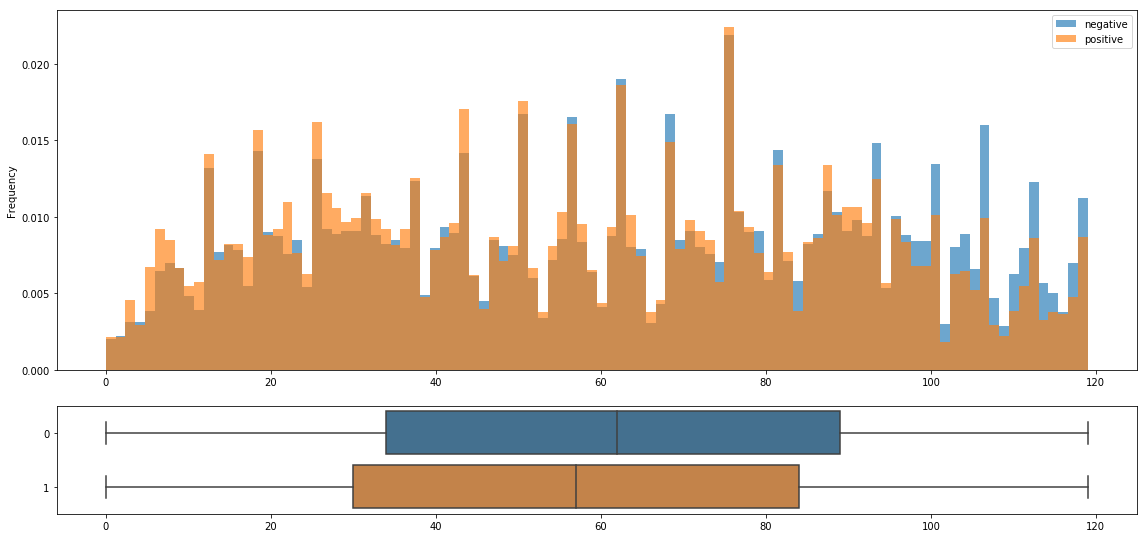

In [26]:
num_visualisation(data.app_day_num,data.default)

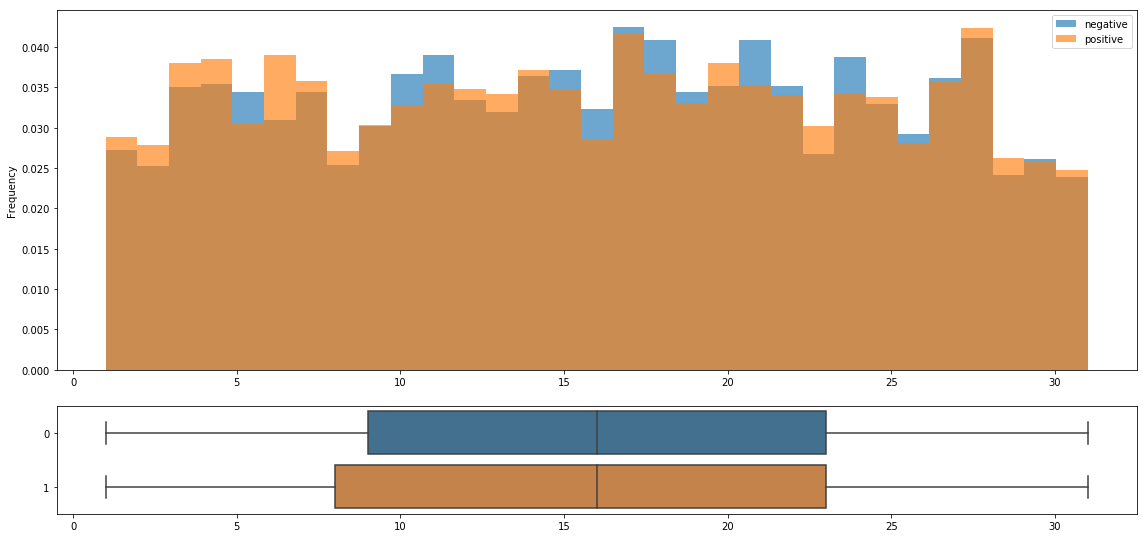

In [27]:
num_visualisation(data.day,data.default)

,0,1,2,3,4,5,6
neg,0.872921,0.872618,0.875724,0.868015,0.88005,0.869032,0.870815
pos,0.127079,0.127382,0.124276,0.131985,0.11995,0.130968,0.129185


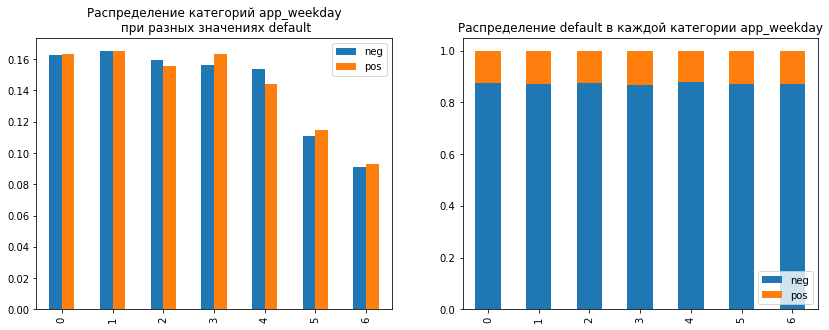

In [28]:
cat_visualisation(data.app_weekday)

,0,1
neg,0.873814,0.869835
pos,0.126186,0.130165


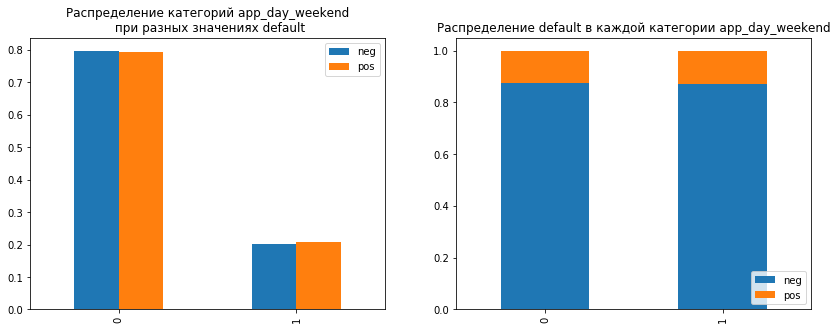

In [29]:
cat_visualisation(data.app_day_weekend)


,0,1
neg,0.875152,0.865288
pos,0.124848,0.134712


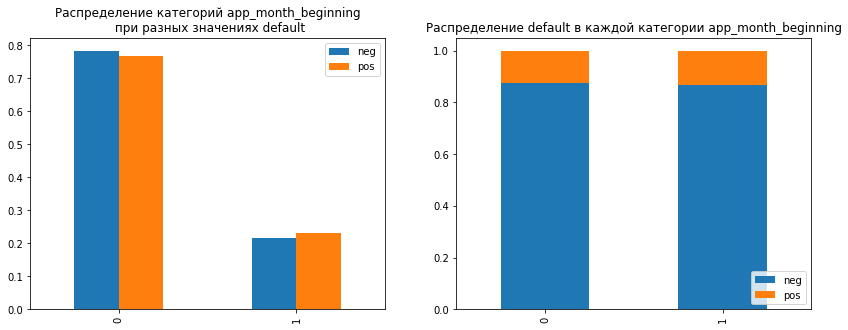

In [30]:
cat_visualisation(data.app_month_beginning)

Дальнейшую предобработку(кодировку, нормировку и т.д.) вновьсозданных признаков произведем одновременно со остальными признаками.

## Количественные признаки
Начнем с общего обзора, потом перейдем к каждому признаку в отдельности. Отмечу, что из рассмотрения не исключен казалось бы неинформативный признак `client_id` - поскольку признаков совсем немного, попробуем и из идентификатора извлечь информацию, а именно предположим что идентификатор отражает хронологический порядок занесения клиента в базу. Если такое предположение верно - признак окажется полезным при анализе, создании новых признаков и обучении модели.

Всего признаков этого типа 6. К ним относятся: client_id, age, decline_app_cnt, score_bki, bki_request_cnt, income


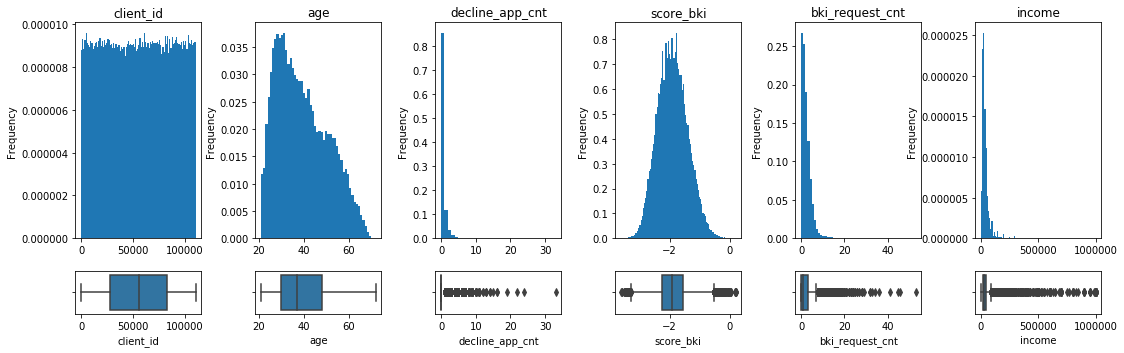

In [31]:
nums_visualisation(data[num_cols], annotation=True)

Как видим, кроме признаков `client_id` и `score_bki`  числовые признаки имеют сильно скошенное вправо распределение. Такая ассиметрия будет мешать линейной модели. Применим логарифмирование: 

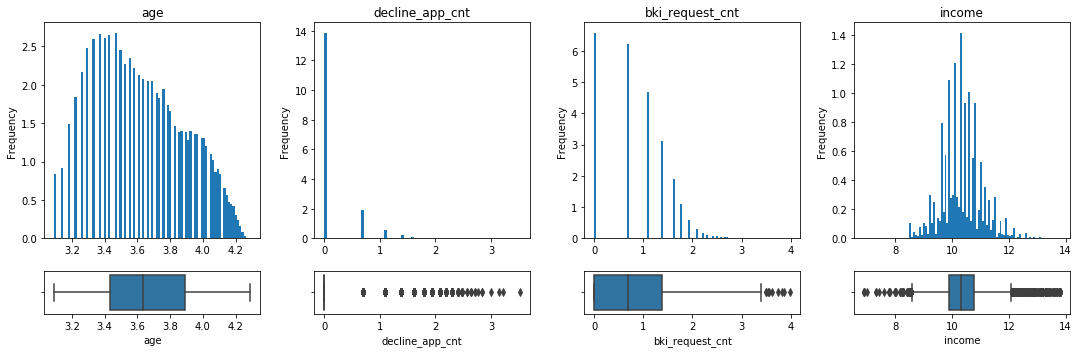

In [32]:
nums_visualisation(np.log(data[num_cols.drop(['client_id','score_bki'] )]+1))

Ситуация улучшилась: логарифмированные `age` и `income` рапсределены похоже на нормально, а в `decline_app_cnt` и `bki_request_cnt` скошенность, судя по boxplot-ам существенно уменьшилась.

Рассмотрим теперь количественные признаки по отдельности. Логарифмируемые признаки будем анализировать сразу с учетом преобразования.


### Age
Согласно описанию - возраст заемщика

Посмториим на распределения отдельно для позитивного и негативного класса целевоцй переменной. Так же поступим и с другими признаками

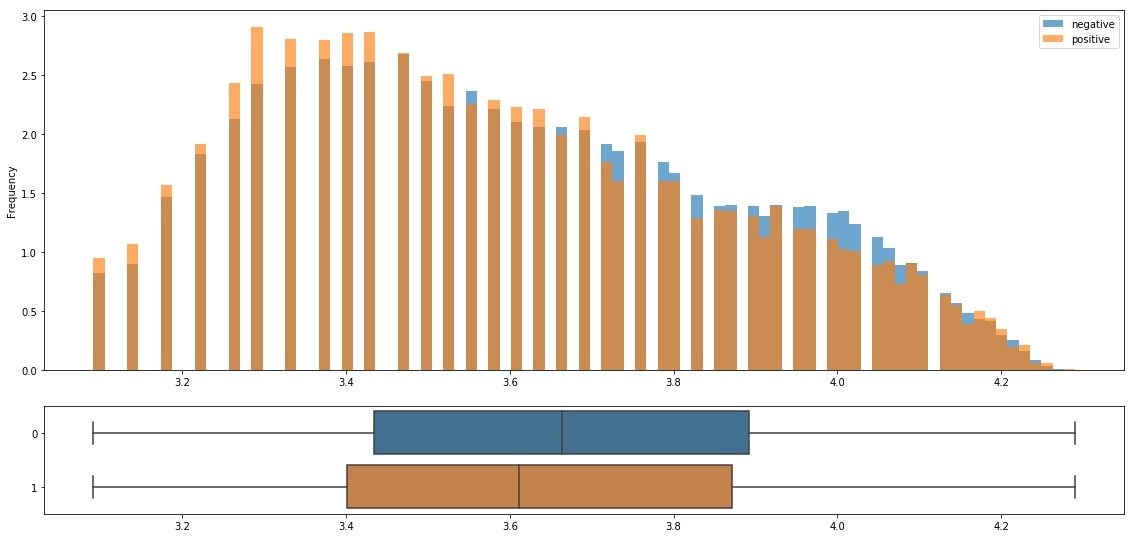

In [33]:
num_visualisation(np.log(data.age+1),data.default)

Дефолтные

### decline_app_cnt
Согласно описанию  - количество отказанных прошлых заявок

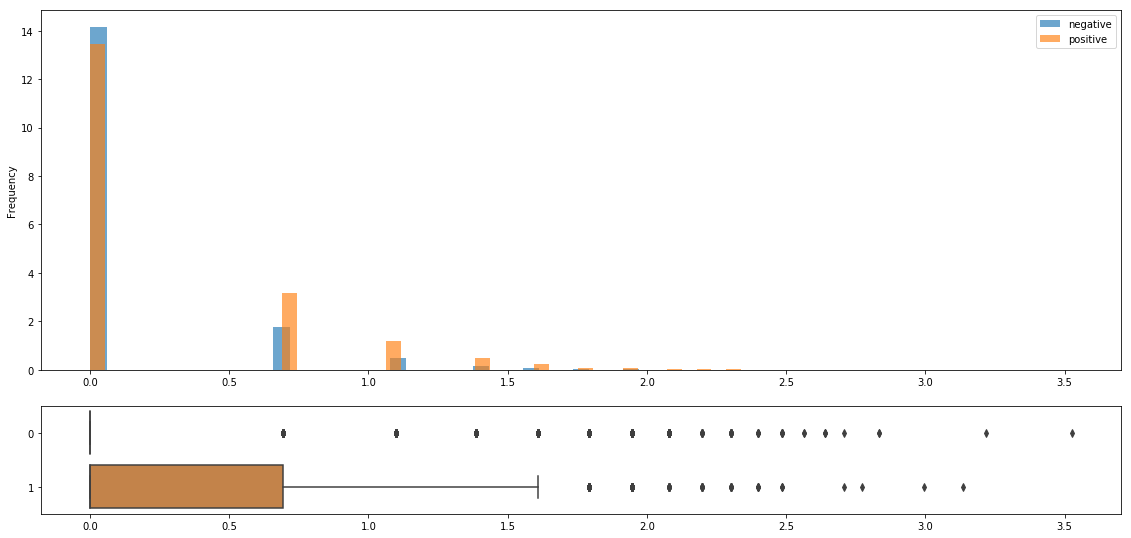

In [34]:
num_visualisation(np.log(data.decline_app_cnt+1),data.default)

текст

### score_bki
Согласно описанию - скоринговый балл по данным из БКИ

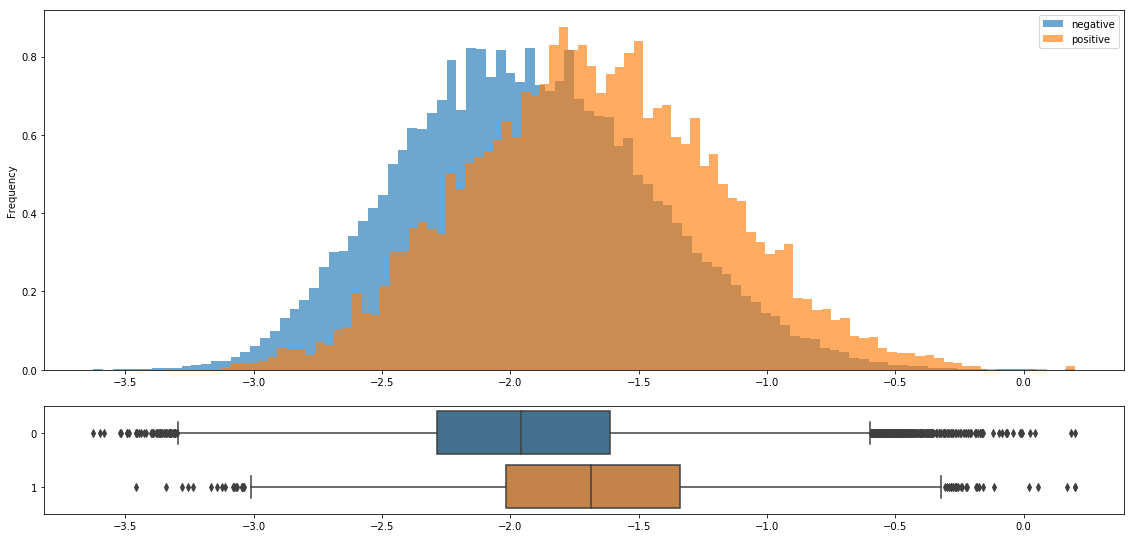

In [35]:
num_visualisation(data.score_bki,data.default)

### bki_request_cnt
Согласно описанию - количество запросов в БКИ

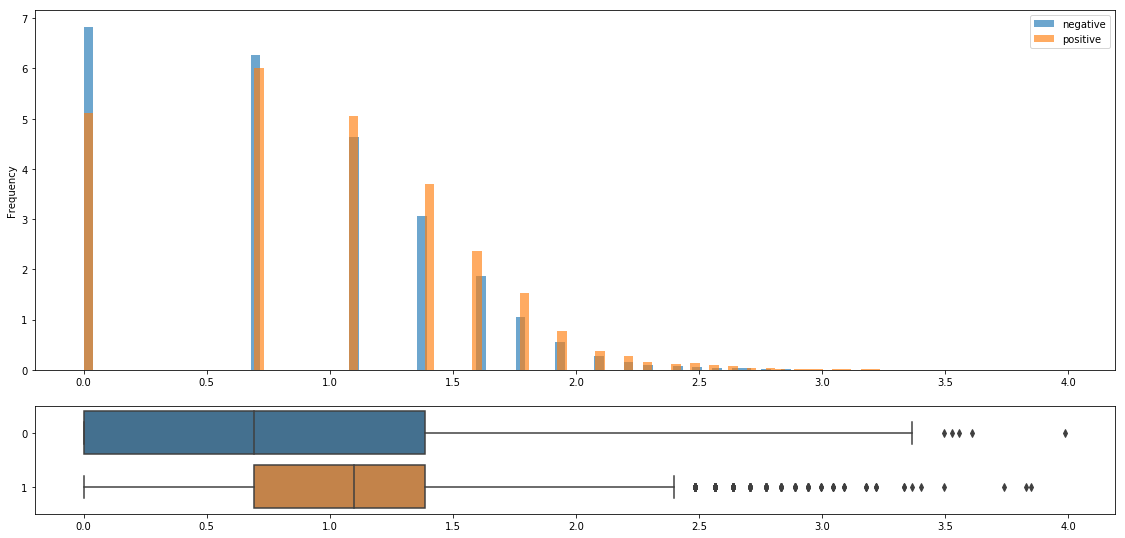

In [36]:
num_visualisation(np.log(data.bki_request_cnt+1),data.default)

Распределение Пуассона?

### income
Согласно описанию - доход заемщика

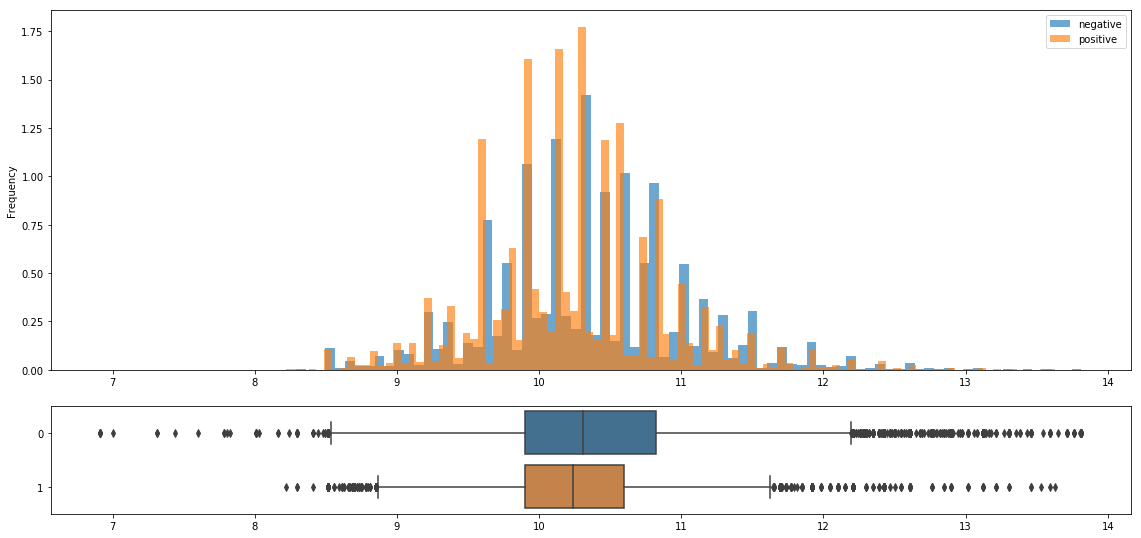

In [37]:
num_visualisation(np.log(data.income+1),data.default)

текст

### client_id
Согласно описанию - идентификатор клиента

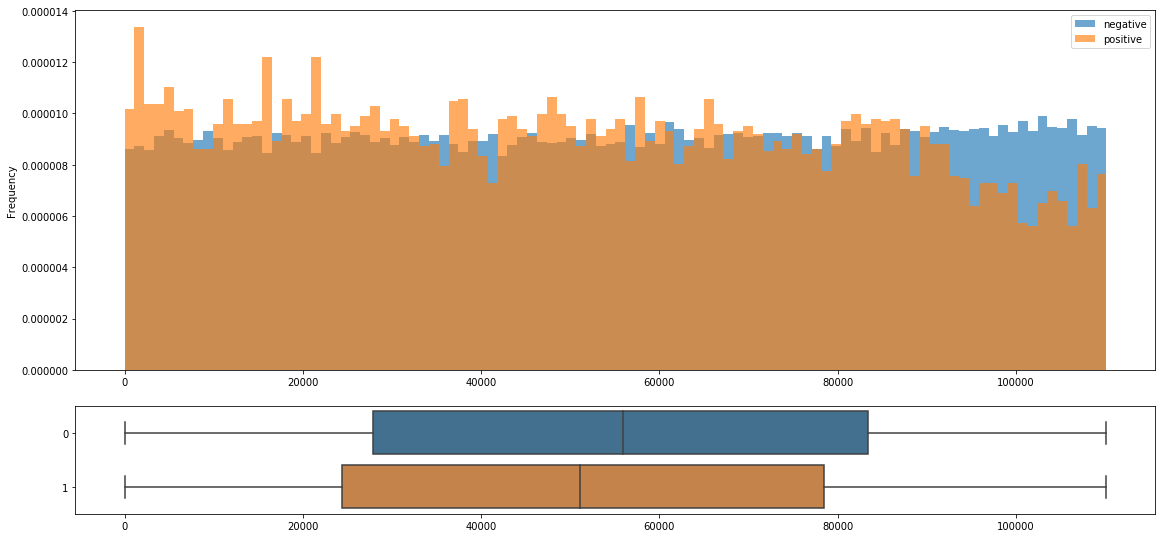

In [38]:
num_visualisation(data.client_id,data.default)

Текст

## Категориальные признаки
Посмотрим на распределение по категориям в каждом признаке:

Всего признаков этого типа 6. К ним относятся: education, region_rating, home_address, work_address, sna, first_time


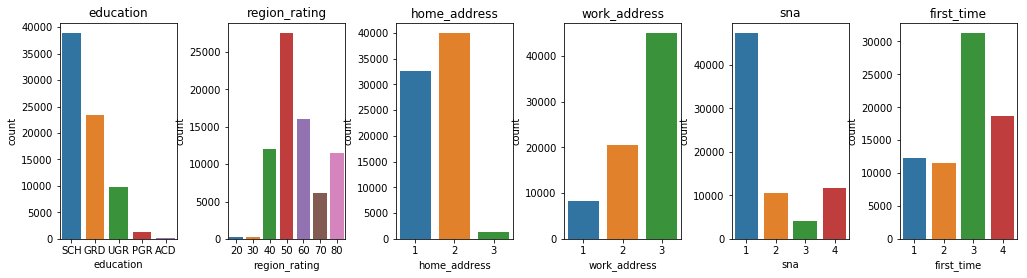

In [39]:
cats_visualisation(data[cat_cols]) 

Как видим распределение по категориям в признаках ...

  .
  .


Расссмотрим каждый признак отдельно:

### education
Согласно описанию - уровень образования

,SCH,GRD,UGR,PGR,ACD
neg,0.849408,0.909908,0.86848,0.935561,0.958763
pos,0.150592,0.090092,0.13152,0.064439,0.041237


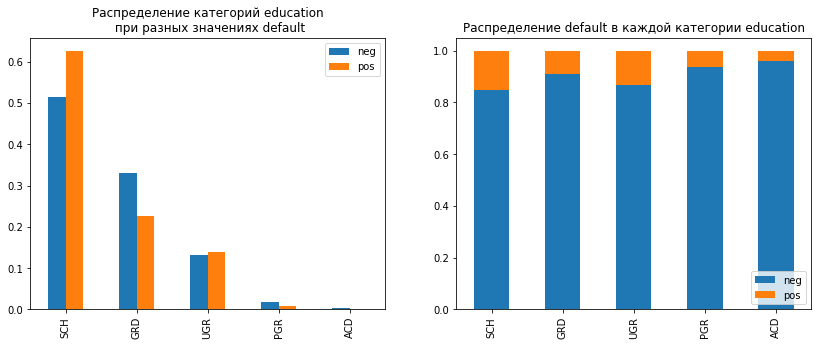

In [40]:
cat_visualisation(data.education)

### region_rating
Согласно описанию - рейтинг региона

,20,30,40,50,60,70,80
neg,0.786408,0.81,0.830298,0.863859,0.871166,0.907566,0.926846
pos,0.213592,0.19,0.169702,0.136141,0.128834,0.092434,0.073154


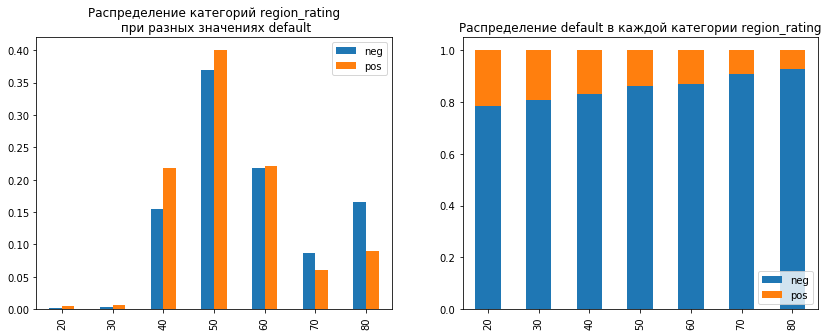

In [41]:
cat_visualisation(data.region_rating)

### home_address
Согласноописанию - категоризатор домашнего адреса

,2,1,3
neg,0.844854,0.907104,0.883943
pos,0.155146,0.092896,0.116057


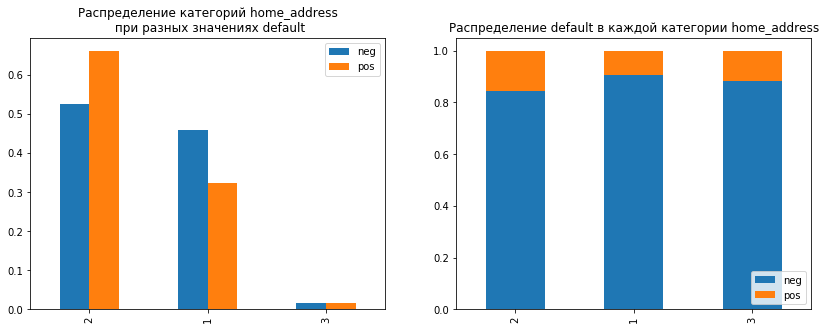

In [42]:
cat_visualisation(data.home_address)

### work_address
Согласно описанию - категоризатор рабочего адреса

,3,2,1
neg,0.852043,0.897493,0.925846
pos,0.147957,0.102507,0.074154


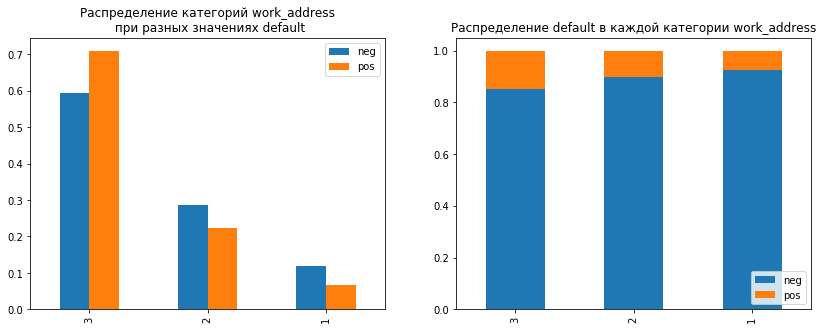

In [43]:
cat_visualisation(data.work_address)

### sna 
Согласно описанию - связь заемщика с клиентами банка

,1,4,2,3
neg,0.901799,0.788493,0.850179,0.842348
pos,0.098201,0.211507,0.149821,0.157652


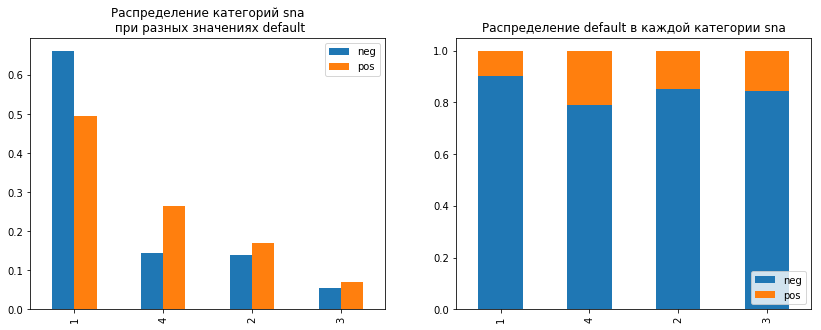

In [44]:
cat_visualisation(data.sna)

### first_time
Согласно описанию - давность наличия информации о заемщике

,1,2,3,4
neg,0.813874,0.844571,0.879731,0.91797
pos,0.186126,0.155429,0.120269,0.08203


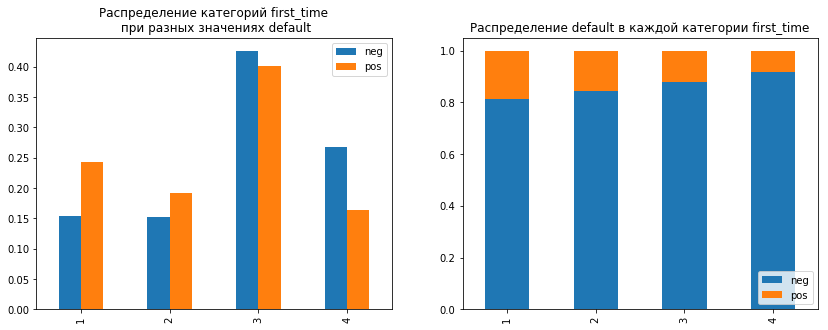

In [45]:
cat_visualisation(data.first_time)

## Бинарные признаки
Теперь рассмотрим бинарные признаки - ........

Всего признаков этого типа 6. К ним относятся: sex, car, car_type, good_work, foreign_passport, default


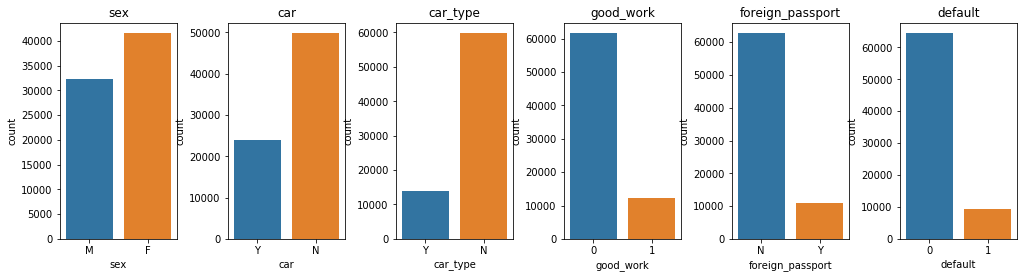

In [46]:
cats_visualisation(data[bin_cols]) 

### sex 
Согласно описанию - пол заемщика

,F,M
neg,0.878759,0.865589
pos,0.121241,0.134411


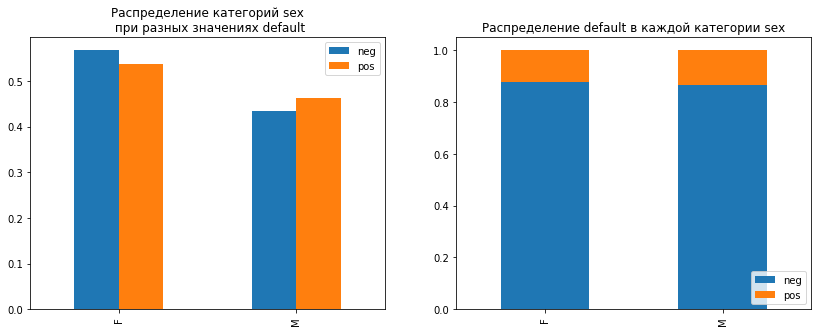

In [47]:
cat_visualisation(data.sex)

### car
Согласно описанию - флаг наличия автомобиля

,N,Y
neg,0.86304,0.893729
pos,0.13696,0.106271


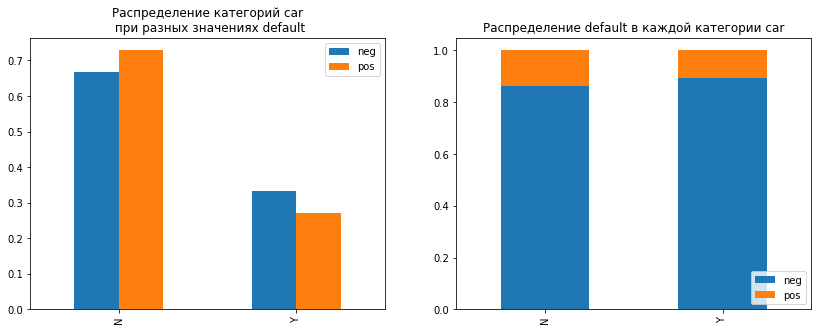

In [48]:
cat_visualisation(data.car)

### car_type
Согласно описанию - флаг автомобиля иномарки

,N,Y
neg,0.863742,0.91255
pos,0.136258,0.08745


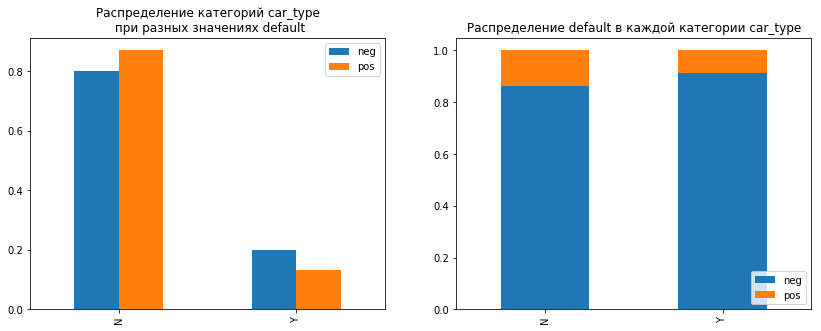

In [49]:
cat_visualisation(data.car_type)

### good_work
Согласно описанию - флаг наличия “хорошей” работы

,0,1
neg,0.866591,0.905498
pos,0.133409,0.094502


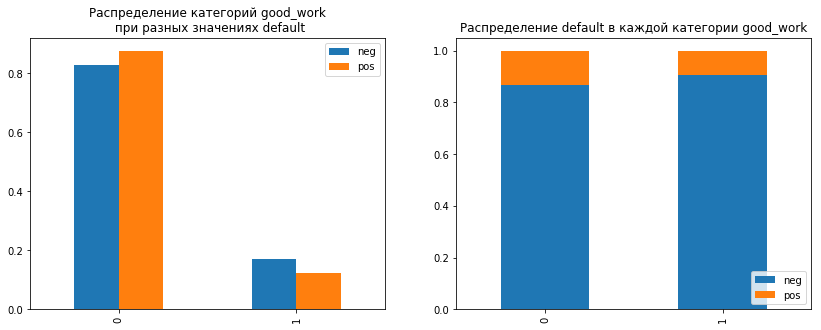

In [50]:
cat_visualisation(data.good_work)

### foreign_passport
Согласно описанию  - наличие загранпаспорта

,N,Y
neg,0.863676,0.925899
pos,0.136324,0.074101


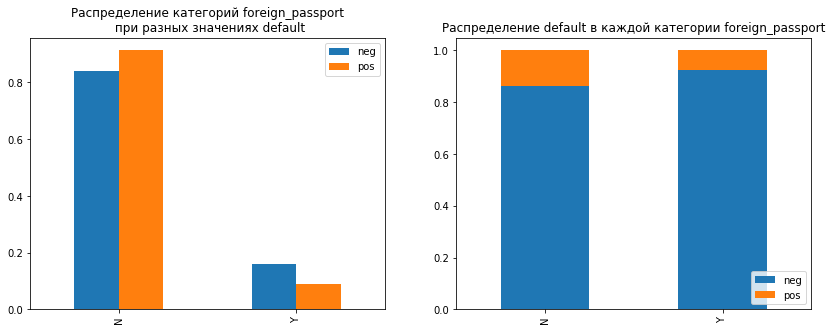

In [51]:
cat_visualisation(data.foreign_passport)

### default

# Первичная предобработка
Осуществим предобработку, согласно выбранным для каждого признака способам.

In [52]:
y = data.default
X = pre_process(data.drop(columns='default'))

# Baseline
Обучим на подготовленных данных модель LogisticRegression() спараметрами по умолчанию и получим значение метрики. Мы будем рассматривать эту модель как первую итерацию, первое приближение которое нужно улучшить.

In [53]:
validation(X, y, LogisticRegression())

0.7344250501183283

# Определение оптимального размера набора данных
В дальнейшем при отборе признаков, при подборе гиперпараметров нам предстоит многократное обучение модели на побучающей выборке. Для того чтобы оптимизировать процесс, проверим зависимость метрики от размера выборки, возможно что начиная с некоторого момента рост размера обучающей выборки перестает ощутимо влиять на качество модели и мы сможет произвести подбор гиперпараметров используя сокращенный/оптимизированный набор данных.

Получим при различных значениях взятой для обучения доли исходных данных значения метрики на тестовой выборке.

In [58]:
%%time
cv = StratifiedKFold(n_splits=5,random_state=RANDOM_SEED)

_, _, test_scores = learning_curve(
       model, X, y, train_sizes=np.linspace(.1, 1.0, 19), cv=cv, scoring = 'roc_auc')

Wall time: 42.6 s


Визуалтзируем полученный результат

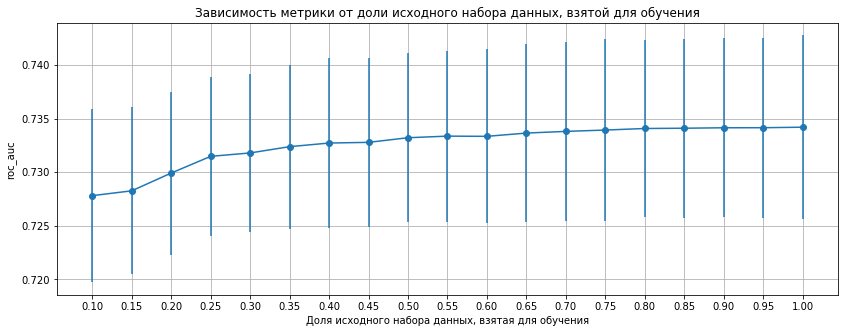

In [59]:
train_prop = np.linspace(.1, 1.0, 19)

test_scores_mean = test_scores.mean(axis=1)
test_scores_std = test_scores.std(axis=1)

plt.figure(figsize=(14,5))
plt.grid(True)
plt.xticks(train_prop)
plt.errorbar(train_prop, test_scores_mean , yerr = test_scores_std, fmt='o-')

plt.title('Зависимость метрики от доли исходного набора данных, взятой для обучения')
plt.ylabel('roc_auc')
plt.xlabel("Доля исходного набора данных, взятая для обучения");

Как видиим в рост постепенно затухает и призначениях 0.75 останавливается. Примем в качестве оптимального с точки зрения затрат времени размер данных в 0.75 от исходного количества

# Создание новых признаков

Сначала создадим признаки осмысленно, основываясь на предположениях о возможных зависимостях

In [60]:
#
data['bki_req_exist'] = (data.bki_request_cnt==0).astype(int)

#
data['decline_app_cnt_exist'] = (data.decline_app_cnt==0).astype(int)

#
data['claster_1'] = data.client_id.lt(10000).astype(int)
data['claster_2'] = data.client_id.between(10000,90000).astype(int)
data['claster_3'] = data.client_id.gt(90000).astype(int)

#
data['pry'] = np.log(data.bki_request_cnt/data.client_id +1)

#
data['persistence'] = np.log(data.decline_app_cnt/data.client_id +1)

# (data.bki_request_cnt/data.decline_app_cnt).value_counts(dropna=False)
#
data['unreliability'] = np.log(data.decline_app_cnt/data.age +1)
#
data['incom_career'] = np.log((data.income/data.age)+1)

#
edu_dict = {'SCH': 1,'UGR': 2,'GRD': 3,'PGR': 4,'ACD': 5}
edu = data.education.fillna(data.education.mode()[0]).map(edu_dict)
data['edu_career'] = np.log((edu/data.age)+1)

#
coolness_car = np.array([2 if x=='Y' else 1  for x in data.car])
coolness_import_car = np.array([2 if x=='Y' else 1  for x in data.car_type])
coolness_pasport =  np.array([2 if x=='Y' else 1  for x in data.foreign_passport])
coolness_work = np.array([2 if x=='Y' else 1  for x in data.good_work])
data['collness'] = coolness_car*coolness_import_car*coolness_pasport*coolness_work

In [61]:
%%time
# Просто осмысленные
y = data.default
X_enriched = pre_process(data.drop(columns='default'))

print(validation(X_enriched, y, LogisticRegression()))

0.7360889054832325
Wall time: 14.3 s


In [65]:
%%time
# Оптимизированные осмысленные
X_enriched_opt, _, y_opt, _ = train_test_split(X_enriched, y, train_size=0.75, stratify=y, random_state=RANDOM_SEED)            

print(validation(X_enriched_opt, y_opt, LogisticRegression()))

0.7353742494438295
Wall time: 11.6 s


# Отбор признаков

### Отбор Lasso

In [66]:
from sklearn.linear_model import Lasso

In [69]:
selector = LogisticRegression(penalty='l1')
selector.fit(X_enriched_opt,y_opt)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [70]:
sorted_by_Lasso = abs(pd.Series(selector.coef_[0],index = X_enriched.columns)).sort_values()
unuseful_features_LR = sorted_by_Lasso[sorted_by_Lasso<0.10].index

In [76]:
model = LogisticRegression(random_state=RANDOM_SEED)
metrics_changes = pd.Series()

for loc in tqdm(range(0,len(unuseful_features_LR),1)):
    to_drop = unuseful_features_LR[:loc] 
    X_tmp = X_enriched_opt.drop(columns=to_drop)
    metrics_tmp = validation(X_tmp,y_opt,model)
    metrics_changes.loc[loc] = metrics_tmp

100%|██████████████████████████████████████████| 34/34 [03:57<00:00,  7.00s/it]


In [77]:
metrics_changes.idxmax(),  metrics_changes.max()

(29, 0.7360156011324754)

In [82]:
to_drop = unuseful_features_LR[:metrics_changes.idxmax()]
X_enriched_opt_select = X_enriched_opt.drop(columns=to_drop)

# Подбор гипнерпараметров

In [90]:
%%time
n_iter = 10
search = pd.Series()

for solver in solvers_hyperparameters:
    hyperparameters = solvers_hyperparameters[solver]
    model = LogisticRegression(solver=solver, random_state=RANDOM_SEED)
    clf = RandomizedSearchCV(model, hyperparameters, n_iter=n_iter, scoring='roc_auc', cv=5, random_state=RANDOM_SEED)
    search[solver] = clf.fit(X_enriched_opt_select, y_opt)

Wall time: 5min 9s


In [113]:
search[best_solver].best_score_

0.7359737463141014

In [143]:
fin_solver = search.apply(lambda x: x.best_score_).idxmax()
search[fin_solver].best_params_

{'penalty': 'l2',
 'intercept_scaling': 100,
 'class_weight': {0: 1, 1: 4},
 'C': 1000.0}

In [116]:
fin_model = LogisticRegression(solver = fin_solver,
                               penalty = fin_params['penalty'],
                               intercept_scaling = fin_params['intercept_scaling'],
                               class_weight = fin_params['class_weight'],
                               C = fin_params['C'])

In [119]:
X_selected = X_enriched.drop(columns=to_drop)
validation(X_selected, y, fin_model)

0.7364446200727685

# Submission

In [195]:
test = pd.read_csv(f'{path}test.csv')

In [196]:
test.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport'],
      dtype='object')

In [197]:
def pre_process_test(data):
    df = data.copy()
    label_encoder = LabelEncoder()
#     scaler = MinMaxScaler()
    scaler = StandardScaler()    
    
    # заполнение пропусков
    df.education.fillna(df.education.mode()[0],inplace=True)
    
    # обработка временного ряда
    df.app_date = df.app_date.apply(lambda x: datetime.strptime(x[:2]+'-'+x[2:5]+'-'+x[5:], '%d-%b-%Y'))
    
    df['app_day_num'] = (df.app_date - df.app_date.min()).dt.days    # день подачи заявки от начала ведения базы данных
    df['day'] = df.app_date.dt.day                                   # число подачи заявки
    df['app_weekday'] = df.app_date.dt.weekday                       # день недели подачи заявки
    df['app_day_weekend'] = df.app_date.dt.weekday.ge(5).astype(int) # день подачи заявки - выходной
    df['app_month_beginning'] = df.app_date.dt.day.le(7).astype(int) # подача заявки в первые 7 дней месяца

    df.drop(columns='app_date',inplace=True)
    
    # разделение на типы призанков
    num_uniq = df.nunique()
    bin_cols = df.columns[num_uniq==2]
    cat_cols = df.columns[(num_uniq>2) & (num_uniq<10)] 
    num_cols = df.columns[num_uniq>=10]
    
    # обработка численных признаков
    for col in num_cols.drop(['client_id','score_bki']):
        df[col] = np.log(df[col]+1)
        
    df[num_cols] = scaler.fit_transform(df[num_cols].values)
    
    # обработка категориальных признаков
    df = pd.get_dummies(df,columns=cat_cols)
    
    # отбработка бинарных признаков
    for col in bin_cols:
        df[col] = label_encoder.fit_transform(df[col])
    
    # удаление client_id
    df.drop(columns='client_id')
        
    return df

In [203]:
#
test['bki_req_exist'] = (test.bki_request_cnt==0).astype(int)

#
test['decline_app_cnt_exist'] = (test.decline_app_cnt==0).astype(int)

#
test['claster_1'] = test.client_id.lt(10000).astype(int)
test['claster_2'] = test.client_id.between(10000,90000).astype(int)
test['claster_3'] = test.client_id.gt(90000).astype(int)

#
test['pry'] = np.log(test.bki_request_cnt/test.client_id +1)

#
test['persistence'] = np.log(test.decline_app_cnt/test.client_id +1)

# (data.bki_request_cnt/data.decline_app_cnt).value_counts(dropna=False)
#
test['unreliability'] = np.log(test.decline_app_cnt/test.age +1)
#
test['incom_career'] = np.log((test.income/test.age)+1)

#
edu_dict = {'SCH': 1,'UGR': 2,'GRD': 3,'PGR': 4,'ACD': 5}
edu = test.education.fillna(test.education.mode()[0]).map(edu_dict)
test['edu_career'] = np.log((edu/test.age)+1)

#
coolness_car = np.array([2 if x=='Y' else 1  for x in test.car])
coolness_import_car = np.array([2 if x=='Y' else 1  for x in test.car_type])
coolness_pasport =  np.array([2 if x=='Y' else 1  for x in test.foreign_passport])
coolness_work = np.array([2 if x=='Y' else 1  for x in test.good_work])
test['collness'] = coolness_car*coolness_import_car*coolness_pasport*coolness_work

In [204]:
X_test = pre_process_test(test)

In [205]:
X_test_selected = X_test.drop(columns=to_drop)

In [209]:
pred = fin_model.predict_proba(X_test_selected)[:,1]

In [216]:
sample_submission.head()

,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501
4,4264,0.304640


In [219]:
submission = pd.DataFrame(dict(client_id = test.client_id,default = pred))

In [220]:
submission.to_csv('submission_1',index=False)

# ОПЫТЫ

In [125]:
fin_model.fit(X_enriched_select,y)

LogisticRegression(C=1000.0, class_weight={0: 1, 1: 4}, dual=False,
          fit_intercept=True, intercept_scaling=100, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [136]:
y_pr = fin_model.predict_proba(X_enriched_select)[:,1]

In [137]:
roc_auc_score(y,y_pr)

0.7376780329536992

## ПОДВАЛ


Всего категориальных  признаков 3. К ним относятся: education, home_address, work_address


MultiIndex(levels=[['ACD', 'GRD', 'PGR', 'SCH', 'UGR'], [0, 1]],
           labels=[[0, 0, 1, 1, 2, 2, 3, 3, 4, 4], [0, 1, 0, 1, 0, 1, 0, 1, 0, 1]],
           names=['education', 'default'])

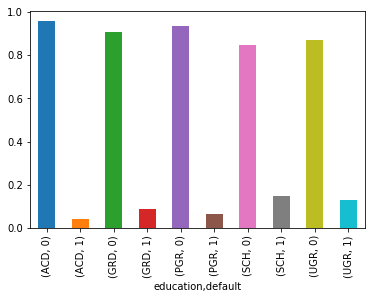

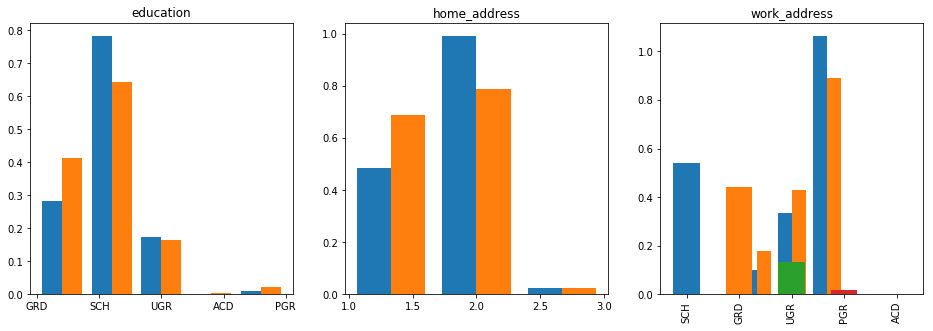

In [41]:
def num_visualisation(row):
    min_diff = pd.Series(row.unique()).sort_values().diff().min()
    bins = min(int((row.max()-row.min()) / min_diff),100)
    bins_range = row.min()-min_diff/2 ,row.max()+min_diff/2 

    fig = plt.figure()
    
    ax1 = fig.add_axes([0, 0.35, 1, 1])
    row.plot.hist(bins=bins,density=True,alpha = 0.5)
    
    ax2 = fig.add_axes([0, 0, 1, 0.2]) 
    ax1.get_shared_x_axes().join(ax1, ax2)
    sns.boxplot(x=row)
    
    plt.tight_layout()    

data.groupby('education').default.value_counts(normalize=True).plot.bar(stacked=True)

df=data[cat_cols]

if 1:
    columns = df.columns
    cols_num = df.shape[1]
    
    fstr = '\033[1m{}\033[0m, '* (len(columns)-1) + '\033[1m{}\033[0m'
    print(('Всего категориальных  признаков {}. К ним относятся: ' + fstr).format(len(columns),*columns))
    
    indent = 0.05
    fig = plt.figure(figsize=(16,5))
    for i,col in enumerate(columns):
        row = df[col]
        bins = row.nunique()
        
        plt.subplot(1,3,i+1)
        plt.title(col)
        plt.hist([data[col][data.default==1].dropna(),data[col][data.default==0].dropna()],
                 density = True, rwidth=None, bins=bins); #align = 'mid'  'left', 'mid', 'right'
        


data.home_address.value_counts(normalize=True).plot.bar()

data.education.value_counts(normalize=True).plot.bar()

aa = data.groupby('education').default.value_counts(normalize=True)
data.groupby('education').default.value_counts(normalize=True).index

## НЫЧКА

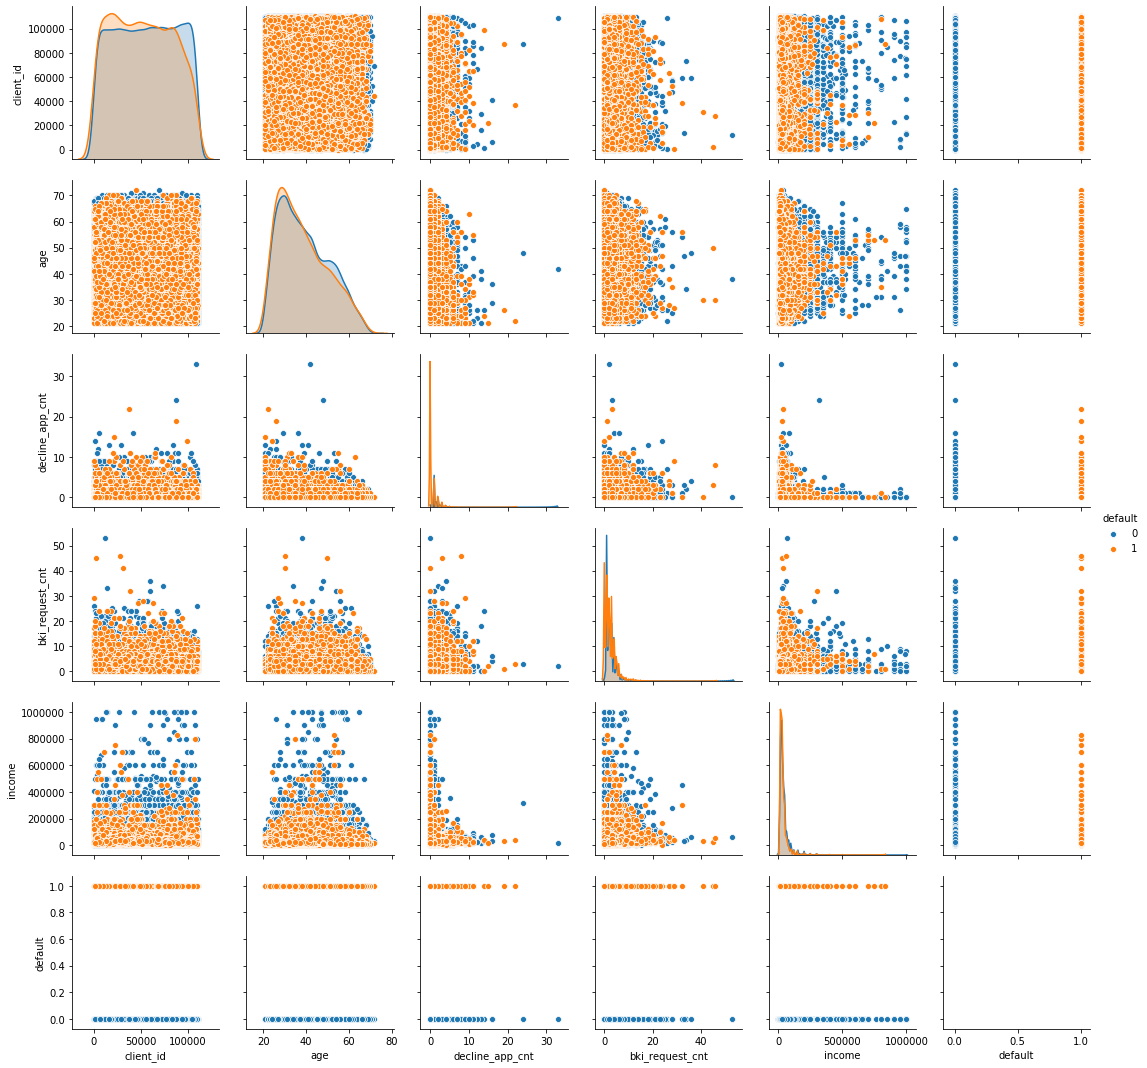

In [63]:
sns.pairplot(data[num_cols.append(pd.Index(['default']))], hue='default')

# Отбор признаков

from tqdm import tqdm
model = LogisticRegression(random_state=RANDOM_SEED)

metrics_threshold = validation(X_opt,y_opt,model)
unuseful_features = pd.Series([])

for col in tqdm(X_opt.columns):
    X_tmp = X_opt.drop(columns=col)
    metrics_tmp = validation(X_tmp,y_opt,model)
    
    if metrics_tmp > metrics_threshold : 
        unuseful_features[col] = metrics_tmp - metrics_threshold

unuseful_features = unuseful_features.sort_values(ascending = False)

unuseful_features

# Baseline + отбор признаков

metrics_changes = pd.Series()

for loc in tqdm(range(0,len(unuseful_features),1)):
    to_drop = unuseful_features.index[:loc] 
    X_tmp = X_opt.drop(columns=to_drop)
    metrics_tmp = validation(X_tmp,y_opt,model)
    metrics_changes.loc[loc] = metrics_tmp
#     print('{:3}  {:.6f}  {:.6f}'.format(loc, MAE_tmp,MAE_round_tmp))

metrics_changes.idxmax(),  metrics_changes.max()

metrics_changes

X_opt_select = X_opt.drop(columns=unuseful_features.index[:metrics_changes.idxmax()] )

# Подбор гиперпараметров

from pprint import pprint

%%time

import warnings
warnings.filterwarnings("ignore")

n_iter = 100
search = pd.Series()

for solver in solvers_hyperparameters:
    hyperparameters = solvers_hyperparameters[solver]
    model = LogisticRegression(solver=solver, random_state=RANDOM_SEED)
    clf = RandomizedSearchCV(model, hyperparameters, n_iter=n_iter, scoring='roc_auc', cv=5, random_state=RANDOM_SEED)
    search[solver] = clf.fit(X_opt_select, y_opt)

search.apply(lambda x: x.best_score_)

search.sag.best_params_

search.apply(lambda x: x.best_score_)

search.sag.best_params_

newton-cg    0.671949
lbfgs        0.671949
liblinear    0.671957
sag          0.672128
saga         0.671949
dtype: float64

{'tol': 0.001,
 'penalty': 'l2',
 'max_iter': 100,
 'class_weight': {0: 1, 1: 4},
 'C': 1000.0}



tuned_solvers_hyperparameters = {}

'''%%time
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

# Добавим типы регуляризации
penalty = ['l1', 'l2']
#
tol = logspace(-8,-3,num=5)
# Зададим ограничения для параметра регуляризации
C = np.logspace(-3, 3, 7)
#
fit_intercept = [True,False]
#
intercept_scaling = [1,10,30]
#
class_weight = ['balanced'] # [{0:0, 1:x} for x in range(1,13,4)]
#
solver = ['newton-cg','lbfgs', 'liblinear', 'sag', 'saga']
#
max_iter [100,300,600]
#
warm_start = [True,False]
# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty, class_weight=class_weight, 
                       solver = solver, intercept_scaling=intercept_scaling)

model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, scoring='roc_auc', cv=5, verbose=0)

best_model = clf.fit(X_opt, y_opt)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])
print('Besr score', clf.best_score_)
''';

In [ ]:
'''%%time
# Просто осмысленные + полиномиальные
from sklearn.preprocessing import PolynomialFeatures
pf = PolynomialFeatures(2)

num_uniq_enriched = data.nunique()
num_cols_enriched = data.columns[num_uniq_enriched>=10]

X_enriched_2 = pd.concat(
    [X_enriched.drop(columns=num_cols_enriched),pd.DataFrame(pf.fit_transform(X_enriched[num_cols_enriched]))],axis=1)

print(validation(X_enriched_2, y, LogisticRegression()))

%%time
# Оптимизированные  осмысленные + полиномиальные
X_enriched_2_opt, _, y_opt, _ = train_test_split(X_enriched_2, y, train_size=0.7, stratify=y, random_state=RANDOM_SEED)   

validation(X_enriched_2_opt, y_opt, LogisticRegression())''';

In [ ]:
'''### Отбор с осмысленными и полиномиальными добавленными

from tqdm import tqdm
model = LogisticRegression(random_state=RANDOM_SEED)

metrics_threshold = validation(X_enriched_2_opt,y_opt,model)
unuseful_features = pd.Series([])

for col in tqdm(X_enriched_2_opt.columns):
    X_tmp = X_enriched_2_opt.drop(columns=col)
    metrics_tmp = validation(X_tmp,y_opt,model)
    
    if metrics_tmp > metrics_threshold : 
        unuseful_features[col] = metrics_tmp - metrics_threshold

unuseful_features = unuseful_features.sort_values(ascending = False)

metrics_changes_2 = pd.Series()

for loc in tqdm(range(0,len(unuseful_features),1)):
    to_drop = unuseful_features.index[:loc] 
    X_tmp = X_enriched_2_opt.drop(columns=to_drop)
    metrics_tmp = validation(X_tmp,y_opt,model)
    metrics_changes_2.loc[loc] = metrics_tmp
    
metrics_changes_2.idxmax(),  metrics_changes_2.max()
    
    '''

### Отбор 'на коленке'

from tqdm import tqdm
model = LogisticRegression(random_state=RANDOM_SEED)

metrics_threshold = validation(X_enriched_opt,y_opt,model)
unuseful_features = pd.Series([])

for col in tqdm(X_enriched_opt.columns):
    X_tmp = X_enriched_opt.drop(columns=col)
    metrics_tmp = validation(X_tmp,y_opt,model)
    
    if metrics_tmp > metrics_threshold : 
        unuseful_features[col] = metrics_tmp - metrics_threshold 

unuseful_features = unuseful_features.sort_values(ascending = False)

metrics_changes = pd.Series()

for loc in tqdm(range(0,len(unuseful_features),1)):
    to_drop = unuseful_features.index[:loc] 
    X_tmp = X_enriched_opt.drop(columns=to_drop)
    metrics_tmp = validation(X_tmp,y_opt,model)
    metrics_changes.loc[loc] = metrics_tmp

metrics_changes.idxmax(),  metrics_changes.max()

In [219]:
sample_submission

,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501
4,4264,0.304640
...,...,...
24349,96657,0.144776
24350,65908,0.878936
24351,74542,0.830871
24352,82350,0.371539
